In [35]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances, search_max_depth_parameter
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, constraint_matrix_to_rules
from tasks.boston_housing import make_task3 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
global_fidelities = {}
local_fidelities = {}
complexities = {}
metrics_per_class = []

## $(0,1)$

In [117]:
focus_class = '(0, 1)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [22]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 13min 36s, sys: 13.4 s, total: 13min 49s
Wall time: 18min 34s


In [118]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [119]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

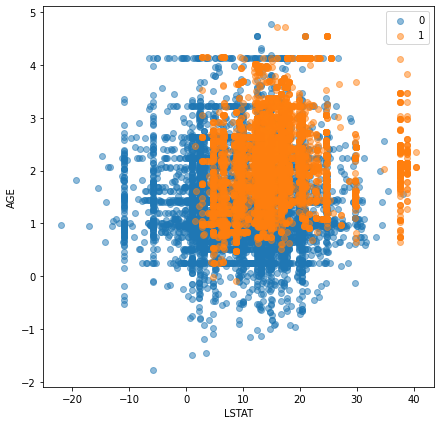

In [9]:
plot_diro2c_2d(explanation, 'LSTAT', 'AGE')

### Find Optimal Solution

In [120]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true, stop=20)
metrics_per_class.append(metrics)

CPU times: user 25.3 s, sys: 206 ms, total: 25.5 s
Wall time: 26.7 s


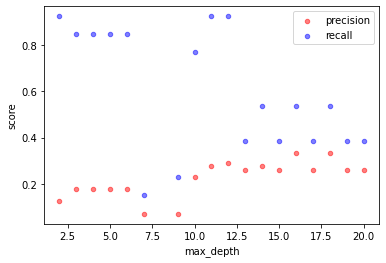

In [121]:
df = metrics.reset_index()
ax = df.plot(kind='scatter', x='index', y='precision', label='precision', color='r', alpha=0.5)
df.plot(kind='scatter', x='index', y='recall', label='recall', color='b', alpha=0.5, ax=ax)
plt.xlabel('max_depth')
plt.ylabel('score');

Unfortunately, no parameter setting explains all instances of the focus class (recall=1.0). But there are three settings with over 90% recall. The setting with max depth 2 will serve as the simpler (global) explanation, and the setting with max depth 11 as the more complete (local) explanation, because it has the highest precision.

In [21]:
metrics[metrics['recall'] > 0.8]

,precision,recall,rules,constraints
2,0.127660,0.923077,1,2
3,0.180328,0.846154,1,3
4,0.180328,0.846154,1,4
5,0.180328,0.846154,2,9
6,0.180328,0.846154,2,11
10,0.179104,0.923077,3,24
11,0.279070,0.923077,3,27


### Tree with depth 2

In [26]:
%%time
max_depth = 4
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 91.9 ms, sys: 5.21 ms, total: 97.1 ms
Wall time: 124 ms


In [37]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.88      0.81      0.84     22513
           1       0.74      0.83      0.78     14828

    accuracy                           0.82     37341
   macro avg       0.81      0.82      0.81     37341
weighted avg       0.82      0.82      0.82     37341



In [39]:
evaluate(explanation, X, y_true)

,Precision,Recall,F1 Score,Support
0,0.988304,0.725322,0.836634,233
1,0.146667,0.846154,0.250000,13


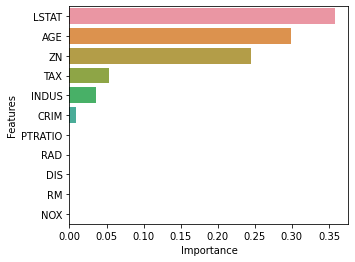

In [27]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

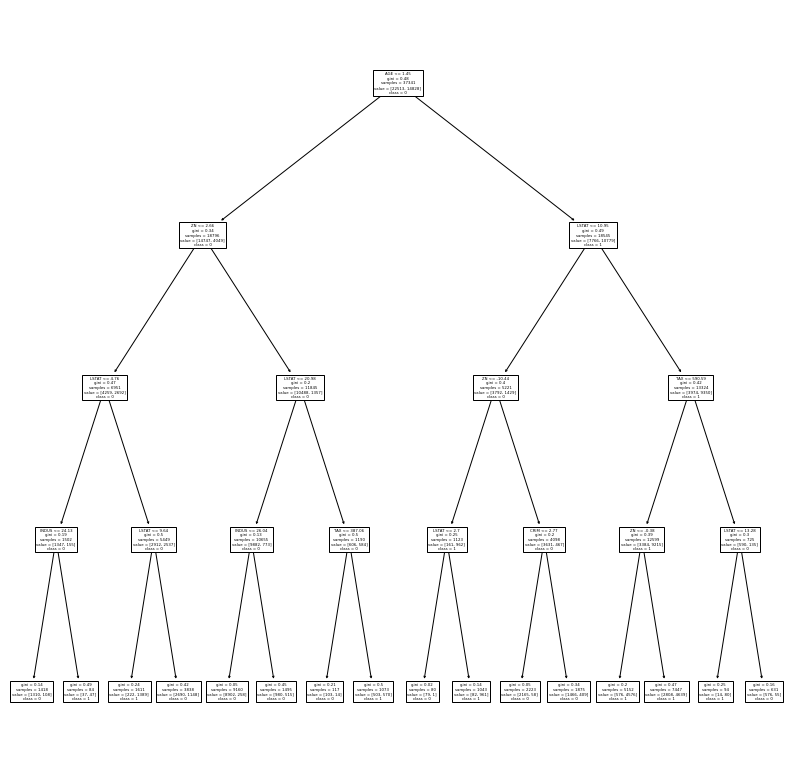

In [28]:
plot_surrogate_tree(explanation, precision=2)

In [31]:
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y_true)
len(rules)

7

In [32]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

8      0
28     1
40     1
42     1
74     1
151    1
152    1
157    1
180    1
196    1
238    0
244    1
245    1
dtype: int64

In [33]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [36]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)
for rule, class_occurences in zip(rules, class_occurences):
    print(f'\item ${rule}$ {class_occurences.astype(int).tolist()}')

\item $\mathit{LSTAT} > 10.95 \land \mathit{AGE} > 1 \land \mathit{ZN} > -0 \land \mathit{TAX} \leq 591$ [2808, 4639]


#### Evaluation

##### Global Fidelity

In [42]:
scores = evaluate(explanation, X, y_true)
global_fidelities[(max_depth, focus_class)] = scores
scores

,Precision,Recall,F1 Score,Support
0,0.988304,0.725322,0.836634,233
1,0.146667,0.846154,0.250000,13


##### Counterfactual Fidelity Error

In [43]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [44]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,NaN,1.00,NaN
ZN,NaN,1.00,1.0
INDUS,NaN,1.00,NaN
NOX,NaN,NaN,NaN
RM,NaN,1.00,NaN
AGE,0.613720,0.00,0.0
DIS,NaN,1.00,NaN
RAD,NaN,1.00,NaN
TAX,138.526888,0.45,0.0
PTRATIO,NaN,1.00,NaN


##### Complexity

In [45]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          1
Constraints    4
dtype: int64

### Tree with depth 11

In [46]:
%%time
max_depth = 11
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 178 ms, sys: 21 ms, total: 199 ms
Wall time: 243 ms


In [54]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     22513
           1       0.89      0.97      0.93     14828

    accuracy                           0.94     37341
   macro avg       0.94      0.95      0.94     37341
weighted avg       0.95      0.94      0.94     37341



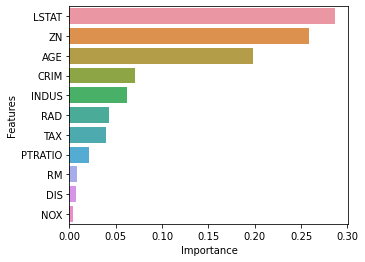

In [47]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [50]:
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y_true)
len(rules)

168

In [51]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

8       0
28     44
40     44
42     39
74     44
151    44
152    44
157    44
180    44
196    44
238    24
244    44
245    39
dtype: int64

In [52]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [53]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)
for rule, class_occurences in zip(rules, class_occurences):
    print(f'\item ${rule}$ {class_occurences.astype(int).tolist()}')

\item $9.64 < \mathit{LSTAT} \leq 15.03 \land -19 < \mathit{ZN} \leq 3 \land 1 < \mathit{AGE} \leq 1 \land 7.96 < \mathit{INDUS} \leq 22.77 \land \mathit{PTRATIO} \leq 20.12$ [33, 97]
\item $18.01 < \mathit{LSTAT} \leq 20.57 \land -0 < \mathit{ZN} \leq 6 \land \mathit{AGE} > 1 \land -5 < \mathit{CRIM} \leq 3 \land \mathit{TAX} \leq 591$ [10, 29]
\item $10.95 < \mathit{LSTAT} \leq 18.01 \land -0 < \mathit{ZN} \leq 4 \land \mathit{AGE} > 1 \land \mathit{CRIM} \leq 4 \land \mathit{INDUS} > 7.94 \land \mathit{RAD} \leq 16.17 \land \mathit{TAX} \leq 591 \land \mathit{PTRATIO} > 12.09$ [10, 25]


#### Evaluation

##### Global Fidelity

In [55]:
scores = evaluate(explanation, X, y_true)
global_fidelities[(max_depth, focus_class)] = scores
scores

,Precision,Recall,F1 Score,Support
0,0.995050,0.862661,0.924138,233
1,0.272727,0.923077,0.421053,13


##### Counterfactual Fidelity Error

In [56]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [57]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,2.136865,0.352941,0.153846
ZN,2.264956,0.000000,0.500000
INDUS,5.240062,0.421053,0.000000
NOX,NaN,NaN,NaN
RM,NaN,1.000000,NaN
AGE,0.631257,0.000000,0.076923
DIS,NaN,1.000000,NaN
RAD,6.142768,0.400000,0.000000
TAX,138.526888,0.500000,0.000000
PTRATIO,6.309417,0.500000,0.200000


##### Complexity

In [58]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules           3
Constraints    27
dtype: int64

## $(1, 2)$

In [59]:
focus_class = '(1, 2)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [6]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 12min 2s, sys: 10.3 s, total: 12min 12s
Wall time: 14min 34s


In [60]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [61]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

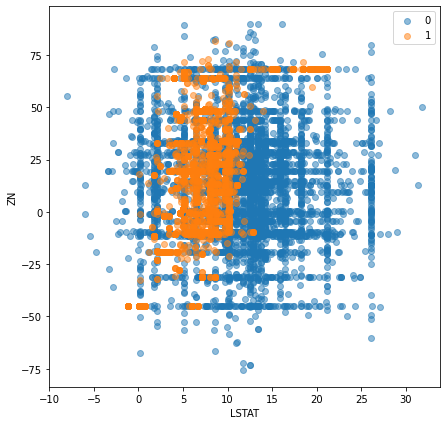

In [62]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### Find Optimal Solution

In [74]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true, stop=20)
metrics_per_class.append(metrics)

CPU times: user 9.99 s, sys: 63.5 ms, total: 10.1 s
Wall time: 10.2 s


Now all parameter settings achieve perfect recall. 10 and 11 are at a local high for precision, while not having too many constraints.

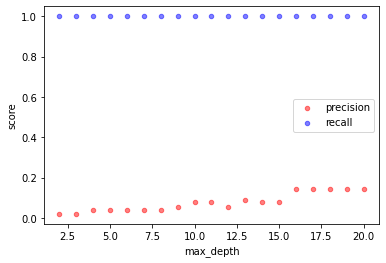

In [75]:
df = metrics.reset_index()
ax = df.plot(kind='scatter', x='index', y='precision', label='precision', color='r', alpha=0.5)
df.plot(kind='scatter', x='index', y='recall', label='recall', color='b', alpha=0.5, ax=ax)
plt.xlabel('max_depth')
plt.ylabel('score');

In [77]:
metrics

,precision,recall,rules,constraints
2,0.019608,1.0,1,2
3,0.019608,1.0,1,3
4,0.038462,1.0,1,4
5,0.038462,1.0,1,5
6,0.038462,1.0,1,6
7,0.038462,1.0,1,6
8,0.038462,1.0,1,6
9,0.055556,1.0,1,7
10,0.076923,1.0,1,7
11,0.076923,1.0,1,7


### Tree with depth 10

In [78]:
%%time
max_depth = 10
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 106 ms, sys: 3.9 ms, total: 110 ms
Wall time: 131 ms


In [86]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     16933
           1       0.98      0.99      0.98      8013

    accuracy                           0.99     24946
   macro avg       0.99      0.99      0.99     24946
weighted avg       0.99      0.99      0.99     24946



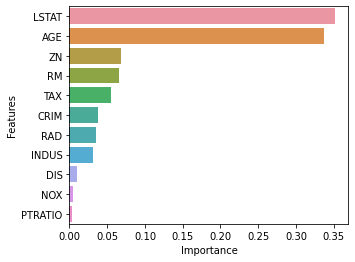

In [79]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [82]:
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y_true)
len(rules)

87

In [83]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

51    2
dtype: int64

In [84]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [85]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)
for rule, class_occurences in zip(rules, class_occurences):
    print(f'\item ${rule}$ {class_occurences.astype(int).tolist()}')

\item $2.10 < \mathit{LSTAT} \leq 11.02 \land \mathit{AGE} \leq 0 \land -31 < \mathit{ZN} \leq 45 \land -3 < \mathit{CRIM} \leq 10$ [8, 1588]


#### Evaluation

##### Global Fidelity

In [87]:
scores = evaluate(explanation, X, y_true)
global_fidelities[(max_depth, focus_class)] = scores
scores

,Precision,Recall,F1 Score,Support
0,1.000000,0.812245,0.896396,245
1,0.021277,1.000000,0.041667,1


##### Counterfactual Fidelity Error

In [88]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [89]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,4.308321,0.0,0.5
ZN,43.942802,0.0,0.5
INDUS,NaN,1.0,NaN
NOX,NaN,NaN,NaN
RM,NaN,1.0,NaN
AGE,0.103568,0.0,0.0
DIS,NaN,1.0,NaN
RAD,NaN,1.0,NaN
TAX,NaN,NaN,NaN
PTRATIO,NaN,1.0,NaN


##### Complexity

In [90]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          1
Constraints    7
dtype: int64

## $(2, 1)$

In [91]:
focus_class = '(2, 1)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [11]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 9min 35s, sys: 6.07 s, total: 9min 41s
Wall time: 10min 13s


In [92]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [93]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

### Find Optimal Solution

In [94]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true, stop=20)
metrics_per_class.append(metrics)

CPU times: user 22.6 s, sys: 273 ms, total: 22.9 s
Wall time: 26.1 s


Unfortunately, no parameter setting covers all instances of the focus class. I'll select max depth 3, because it has the highest precision among those, that have the highest recall.

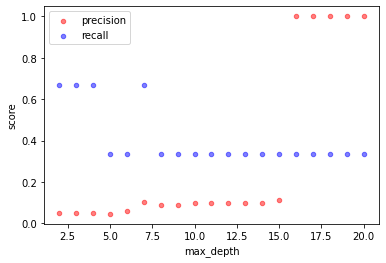

In [95]:
df = metrics.reset_index()
ax = df.plot(kind='scatter', x='index', y='precision', label='precision', color='r', alpha=0.5)
df.plot(kind='scatter', x='index', y='recall', label='recall', color='b', alpha=0.5, ax=ax)
plt.xlabel('max_depth')
plt.ylabel('score');

In [96]:
metrics

,precision,recall,rules,constraints
2,0.048780,0.666667,1,2
3,0.051282,0.666667,1,3
4,0.051282,0.666667,1,4
5,0.045455,0.333333,1,5
6,0.058824,0.333333,1,6
7,0.105263,0.666667,2,14
8,0.090909,0.333333,1,7
9,0.090909,0.333333,1,8
10,0.100000,0.333333,1,9
11,0.100000,0.333333,1,9


### Tree with depth 3

In [98]:
%%time
max_depth = 3
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 54.1 ms, sys: 3.58 ms, total: 57.7 ms
Wall time: 63.8 ms


In [99]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.91      0.79      0.85     17980
           1       0.78      0.91      0.84     15085

    accuracy                           0.84     33065
   macro avg       0.85      0.85      0.84     33065
weighted avg       0.85      0.84      0.84     33065



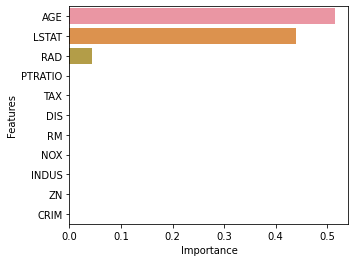

In [100]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [101]:
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y_true)
len(rules)

2

In [102]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

34     1
77     0
101    1
dtype: int64

In [103]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [104]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)
for rule, class_occurences in zip(rules, class_occurences):
    print(f'\item ${rule}$ {class_occurences.astype(int).tolist()}')

\item $\mathit{AGE} > 2 \land 2.87 < \mathit{LSTAT} \leq 12.96$ [3684, 13023]


#### Evaluation

##### Global Fidelity

In [105]:
scores = evaluate(explanation, X, y_true)
global_fidelities[(max_depth, focus_class)] = scores
scores

,Precision,Recall,F1 Score,Support
0,0.995169,0.847737,0.915556,243
1,0.051282,0.666667,0.095238,3


##### Counterfactual Fidelity Error

In [106]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [107]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,NaN,1.0,NaN
ZN,NaN,1.0,NaN
INDUS,NaN,1.0,NaN
NOX,NaN,NaN,NaN
RM,NaN,1.0,NaN
AGE,0.561769,0.0,0.0
DIS,NaN,1.0,NaN
RAD,NaN,1.0,NaN
TAX,NaN,1.0,NaN
PTRATIO,NaN,1.0,NaN


##### Complexity

In [108]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          1
Constraints    3
dtype: int64

# Summary

In [109]:
def map_index(index):
    class_, depth = index[0], index[1]
    if class_ == '(0, 1)' and depth == 2:
        level = 'global'
    elif class_ == '(0, 1)' and depth == 11:
        level = 'local'
    elif class_ == '(1, 2)' and depth == 10:
        level = 'global'
    elif class_ == '(2, 1)' and depth == 3:
        level = 'global'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [110]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('depth', 'class'))
global_fidelity = global_fidelity[global_fidelity.index.get_level_values(2).astype(int) == 1]
global_fidelity.index = global_fidelity.index.droplevel(2)
global_fidelity = global_fidelity.reorder_levels(['class', 'depth']).sort_index()
global_fidelity

Precision    Recall  F1 Score  Support
class  depth                                        
(0, 1) 4       0.146667  0.846154  0.250000       13
       11      0.272727  0.923077  0.421053       13
(1, 2) 10      0.021277  1.000000  0.041667        1
(2, 1) 3       0.051282  0.666667  0.095238        3

## Local Fidelity

In [111]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('depth', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'depth', 'feature']).sort_index()
local_fidelity

RMSE       BMR       BAR
class  depth feature                                
(0, 1) 4     AGE        0.613720  0.000000  0.000000
             CRIM            NaN  1.000000       NaN
             DIS             NaN  1.000000       NaN
             INDUS           NaN  1.000000       NaN
             LSTAT      4.274667  0.500000  0.000000
             NOX             NaN       NaN       NaN
             PTRATIO         NaN  1.000000       NaN
             RAD             NaN  1.000000       NaN
             RM              NaN  1.000000       NaN
             TAX      138.526888  0.450000  0.000000
             ZN              NaN  1.000000  1.000000
       11    AGE        0.631257  0.000000  0.076923
             CRIM       2.136865  0.352941  0.153846
             DIS             NaN  1.000000       NaN
             INDUS      5.240062  0.421053  0.000000
             LSTAT      3.172787  0.000000  0.000000
             NOX             NaN       NaN       NaN
             PTRATIO    6.309417  0.500000  0.200000
             RAD        6.142768  0.400000  0.000000
             RM              NaN  1.000000       NaN
             TAX      138.526888  0.500000  0.000000
             ZN         2.264956  0.000000  0.500000
(1, 2) 10    AGE        0.103568  0.000000  0.000000
             CRIM       4.308321  0.000000  0.500000
             DIS             NaN  1.000000       NaN
             INDUS           NaN  1.000000       NaN
             LSTAT      3.764692  0.000000  0.000000
             NOX             NaN       NaN       NaN
             PTRATIO         NaN  1.000000       NaN
             RAD             NaN  1.000000       NaN
             RM              NaN  1.000000       NaN
             TAX             NaN       NaN       NaN
             ZN        43.942802  0.000000  0.500000
(2, 1) 3     AGE        0.561769  0.000000  0.000000
             CRIM            NaN  1.000000       NaN
             DIS             NaN  1.000000       NaN
             INDUS           NaN  1.000000       NaN
             LSTAT      4.562230  0.000000  0.000000
             NOX             NaN       NaN       NaN
             PTRATIO         NaN  1.000000       NaN
             RAD             NaN  1.000000       NaN
             RM              NaN  1.000000       NaN
             TAX             NaN  1.000000       NaN
             ZN              NaN  1.000000       NaN

## Complexity

In [112]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('depth', 'class')).T
complexity = complexity.reorder_levels(['class', 'depth']).sort_index()
complexity

Rules  Constraints
class  depth                    
(0, 1) 4          1            4
       11         3           27
(1, 2) 10         1            7
(2, 1) 3          1            3

## Generation Time

approx. 47m

In [113]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('depth').notnull()]
global_fidelity.index.rename(['class', 'level'], inplace=True)

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('depth').notnull()]
local_fidelity.index.rename(['class', 'level', 'feature'], inplace=True)

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('depth').notnull()]
complexity.index.rename(['class', 'level'], inplace=True)

with open('results.soa.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)

# Additional Plots

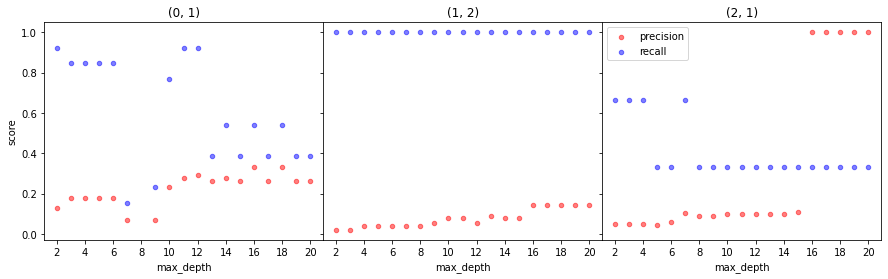

In [125]:
fig, axs = plt.subplots(ncols=3, sharex='all', sharey='all', figsize=(3*5, 4))
for label, metrics, ax in zip(['(0, 1)', '(1, 2)', '(2, 1)'], metrics_per_class, axs):
    show_legend = ax == axs[-1]
    df = metrics.reset_index()
    df.plot(kind='scatter', x='index', y='precision', label='precision', color='r', alpha=0.5, legend=show_legend, ax=ax)
    df.plot(kind='scatter', x='index', y='recall', label='recall', color='b', alpha=0.5, legend=show_legend, ax=ax)
    ax.set_xlabel('max_depth')
    ax.set_ylabel('score')
    ax.set_title(label)
    plt.subplots_adjust(wspace=.0, hspace=.0)
    plt.xticks([i for i in range(1, 21) if i%2 != 1])
plt.savefig('boston-soa-pr-curve.pdf')